<span style="font-size:10pt">Copyright Jean-Luc CHARLES $-$ 2025/03/14 $-$ CC BY-SA 4.0 $-$  <img src="img/CC-BY-SA.jpeg" width="50"></span> 

<span style="font-size:10pt">Copyright Jean-Luc CHARLES $-$ 2025/03/14 $-$ CC BY-SA 4.0 $-$  <img src="img/CC-BY-SA.jpeg" width="50"></span> 

# Training Reproducibility with tensorflow

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
    It is fundamental to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for each important Python project: the PVE makes it possible to control for each project the versions of the Python interpreter and "sensitive" modules (like tensorflow for example).</span></div>

This notebook should be run with tensorflow 2.16.2

## 1 - Import the required Python modules

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #suppress the numerous TensorFlow warnings

import tensorflow as tf
from tensorflow import keras

import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time
from cpuinfo import get_cpu_info

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# specific modules:
from utils.tools import (scan_dir, 
                         plot_images, 
                         plot_loss_accuracy, 
                         plot_loss_accuracy_vs_hyperparam,
                         elapsed_time_since, 
                         show_conf_matrix, 
                         plot_proportion_bar)

print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} with keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.12.3
tensorflow: 2.16.2 with keras 3.8.0
numpy     : 1.26.4
OpenCV    : 4.11.0


In [2]:
# allows to visualize the graphs directly in the cell of the notebook:
%matplotlib inline

Set the seed if needed, for all the random generators:

In [3]:
SEED = 1234

## 2 - Load the MNIST dataset (images and labels)

We use the keras `load_data` function to load the data from the MNIST 
(see [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data)):<br>
- `im_train`, `lab_train` are the training images and labels,
- `im_valid`, `lab_valid` are the validation images and labels.

In [4]:
(im_train, lab_train), (im_valid, lab_valid) = keras.datasets.mnist.load_data()

Let's check the `shape` and `dtype` attributes of the numpy arrays:

In [5]:
print(f"im_train.shape:  {im_train.shape}, dtype: {im_train.dtype}")
print(f"im_valid.shape:  {im_valid.shape}, dtype: {im_valid.dtype}")
print(f"lab_train.shape: {lab_train.shape}, dtype: {lab_train.dtype}")
print(f"lab_vaild.shape: {lab_valid.shape}, dtype: {lab_valid.dtype}")

im_train.shape:  (60000, 28, 28), dtype: uint8
im_valid.shape:  (10000, 28, 28), dtype: uint8
lab_train.shape: (60000,), dtype: uint8
lab_vaild.shape: (10000,), dtype: uint8


### Visualization of images and labels:

The local module `utils.tools` defines the `plot_images` function which can be used to diplay a grid of MINIT images.<br>
Let's plot a grid of images 4 x 6 geginning with the 600th image:

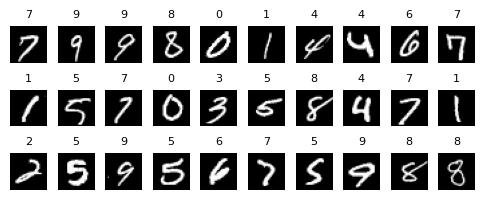

In [6]:
plot_images(im_train, 3, 10, 599, label_array=lab_train)

### Create the 3 datasets: tain, validation & test

To follow the _state of the art_, we will split the whole dataset into train, validation & test datasets.<br>
A simple way to do this is to keep the train dataset and to split of the current validation dataset in two equal subsets:
- a new smaller validation set,
- a new test set.

In [7]:
# note on train_test_split : Stratified train/test split is not implemented for shuffle=False 

im_valid, im_test, lab_valid, lab_test = train_test_split(im_valid, lab_valid,
                                                          stratify=lab_valid,
                                                          test_size=0.5,
                                                          shuffle=True,
                                                          random_state=SEED)

We can verify that the proportion of digits remains homogenous in all the datasets:

In [8]:
prop = {}
prop['valid'] = [ (lab_valid == i).sum() for i in range(10)]
prop['test']  = [ (lab_test  == i).sum() for i in range(10)]

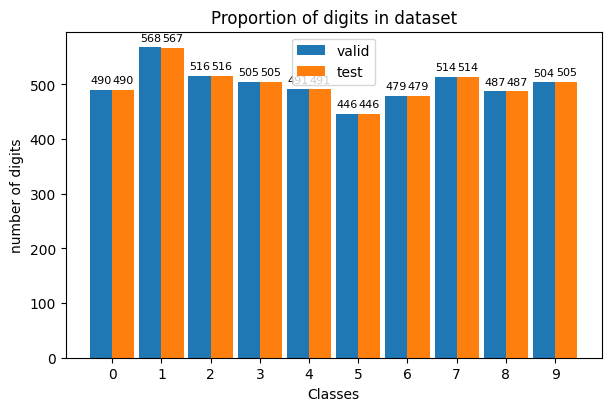

In [9]:
plot_proportion_bar(prop, range(10))

### Setting useful parameters:

To avoid hard-coding the number of training and test images as well as the size of the images, these parameters are recovered from the data set:
- with the shape attribute of the image arrays
- with the size attribute of the first training image for example

In [10]:
# number of training images:
NB_IM_TRAIN = im_train.shape[0]
NB_IM_VALID = im_valid.shape[0]     
NB_IM_TEST  = im_test.shape[0]     

# number of classes:
NB_CLASS = len(set(lab_train))
print(f"{NB_CLASS} different classes found in the `lab_train` ndarray")

10 different classes found in the `lab_train` ndarray


## 3 - Pre-process input dataset

### Reshape the data arrays to fit keras requirements

The convolutional layers of **keras** take by default arrays of shape `(batch_size, height, width, depth)` :
- `batch_size` : umber of images in a batch of input date,
- `height` et `width` : the size of the images in pixels,
- `depth` : color dimension (`3` for a RGB image, `1` for a grey tone image).

The current shapes of the input arrays ares :

In [11]:
im_train.shape, im_valid.shape, im_test.shape

((60000, 28, 28), (5000, 28, 28), (5000, 28, 28))

We must add the dimension `depth` (value: 1 for grey tone images) after the third dimension `width`, for example using the method `reshape` of the class `ndarray`.<br>
We also normalize the input arrays so that their elements are in [0, 1]. 

In [12]:
x_train = im_train.reshape(im_train.shape + (1,))/255
x_valid = im_valid.reshape(im_valid.shape + (1,))/255
x_test  = im_test.reshape(im_test.shape + (1,))/255

# check:
print(f'train:  {im_train.shape} -> {x_train.shape},  min: {x_train.min()}, max: {x_train.max()}')
print(f'valid:  {im_valid.shape} -> {x_valid.shape},  min: {x_valid.min()}, max: {x_valid.max()}')
print(f'test :  {im_test.shape}  -> {x_test.shape},  min: {x_test.min()}, max: {x_test.max()}')

# image shape:
IM_SHAPE = x_train[0].shape

# Visual checking:
print(f"Image size: {IM_SHAPE}")

train:  (60000, 28, 28) -> (60000, 28, 28, 1),  min: 0.0, max: 1.0
valid:  (5000, 28, 28) -> (5000, 28, 28, 1),  min: 0.0, max: 1.0
test :  (5000, 28, 28)  -> (5000, 28, 28, 1),  min: 0.0, max: 1.0
Image size: (28, 28, 1)


### *one-hot* encoding of the label arrays:

We use the **keras** `to_categorical` function (see [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)) to define the `y_train`, `y_valid` and `y_test` arrays containing the *hot-one* encoded version of `lab_train`, `lab_valid` and `lab_test`:

In [13]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' of labels :
y_train = to_categorical(lab_train)
y_valid = to_categorical(lab_valid)
y_test  = to_categorical(lab_test)

Let's check the first 10 values of the `lab_train` and `y_train` arrays:

In [14]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## 4 - Build the Convolutional Neural Network (CNN)

We build a CNN similar to __LeNet5__ introduced in the research paper “Gradient-Based Learning Applied To Document Recognition” in 1998 by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffnerfrom.

![img/LeNet5.png](img/LeNet5.png)

In the rest of this notebook, we will build the CNN many times so we define the function `build_CNN`:

In [15]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, AveragePooling2D, MaxPool2D, Flatten

def build_CNN(input_shape, seed=None):

    if seed != None:
        # Deterministic tensorflow training: 
        # 1/ set the seed of the random generators involved with tensorflow:
        tf.keras.utils.set_random_seed(seed)
        # 2/ make the tf aps determinisctic 
        # [see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html]
        tf.config.experimental.enable_op_determinism()         
    
    model = Sequential(name='LeNet5')
    
    # A layer to give the 4 dimensions of the input data:
    model.add(Input(shape=input_shape))
    
    # Layer C1: 6 convolution filters of 5x5 with padding and 'relu' activation function:
    model.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', name='C1'))
    
    # Layer S2: 'maximum' poolling stage, with 2x2:
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='S2'))
    
    # Layer C3: 16 convolution filters of 5x5 with padding and 'relu' activation function:
    model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu', name='C3'))
    
    # Layer S4: 'maximum' poolling stage, with 2x2:
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='S4'))
    
    # Flatten the images into a single vector with all the pixels:
    model.add(Flatten())

    # Layer C5: dense layer with 120 neurons and 'relu' activation function:
    model.add(Dense(120, activation='relu', name='C5'))
    
    # F6: dense layer with 84 neurones and 'relu' activation function:
    model.add(Dense(84, activation='relu', name='F6'))
    
    # Output: final dense layer, with 'NB_CLASS'(10) neutones and the 'softmax' 
    # activation function dedicated to classification training:
    model.add(Dense(NB_CLASS, activation='softmax', name='Output'))    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [16]:
model = build_CNN(IM_SHAPE)
model.summary()

Model: "LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                     │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2 (MaxPooling2D)               │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4 (MaxPooling2D)               │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C5 (Dense)                      │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F6 (Dense)                      │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

## 5 - Hyper-Parameters influence

In [17]:
print(f'{IM_SHAPE=}')
print(f'{NB_CLASS=}')

IM_SHAPE=(28, 28, 1)
NB_CLASS=10


### Run several training with different values of batch_size

In [18]:
H, R = [], []
nb_epoch = 15

for bs in (16, 32, 64, 256, 512, 1024):
    print(f'batch_size={bs}, {SEED=}', end="")
    t0 = time()
    
    # Build a new model at each lopp lap, with seed set:
    model = build_CNN(IM_SHAPE, seed=SEED)
        
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=nb_epoch,  # the total number of successive trainings
                     batch_size=bs,    # split the train dataset in multiple batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    
    elaps = elapsed_time_since(t0)
    print(f' Train {elaps}', flush=True) 
    
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    predict_labels = np.argmax(model.predict(x_test, verbose=0), axis=-1)
    R.append({'evaluate':(test_loss, test_acc), 'elaps':elaps, 'y_test':y_test, 'predict_labels':predict_labels})

    hist.params['nb_epoch']   = nb_epoch
    hist.params['batch_size'] = bs
    hist.params['seed']       = SEED
    hist.params['elaps']      = elaps
    H.append(hist)  


batch_size=16, SEED=1234 Train Elapsed time 113s -> 00:01:53
batch_size=32, SEED=1234 Train Elapsed time 60s -> 00:01:00
batch_size=64, SEED=1234 Train Elapsed time 36s -> 00:00:36
batch_size=256, SEED=1234 Train Elapsed time 12s -> 00:00:12
batch_size=512, SEED=1234 Train Elapsed time 9s -> 00:00:09
batch_size=1024, SEED=1234 Train Elapsed time 8s -> 00:00:08


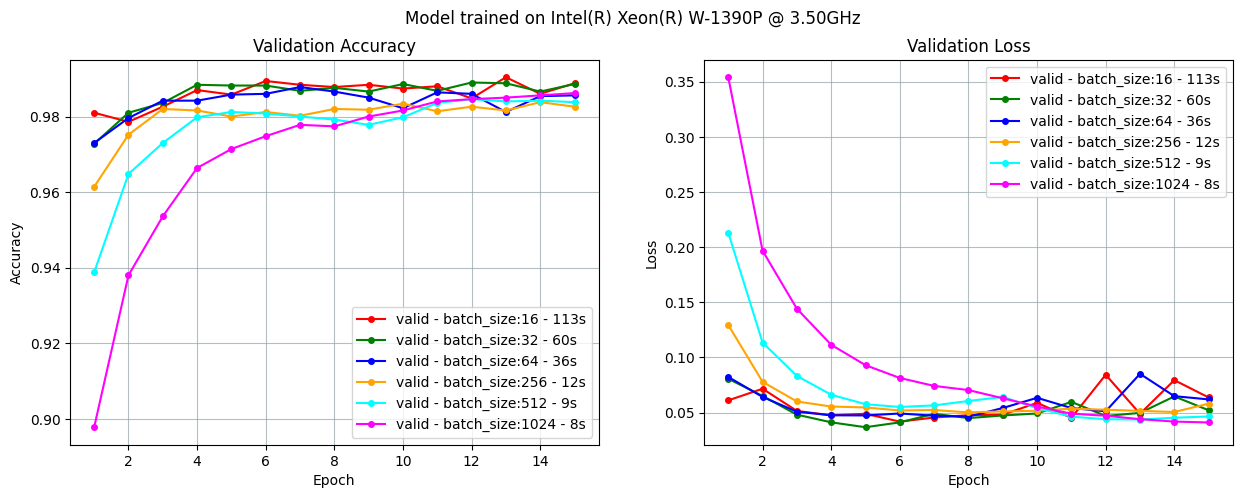

In [19]:
plot_loss_accuracy_vs_hyperparam(H, NB_IM_TRAIN, plot_train=False,)

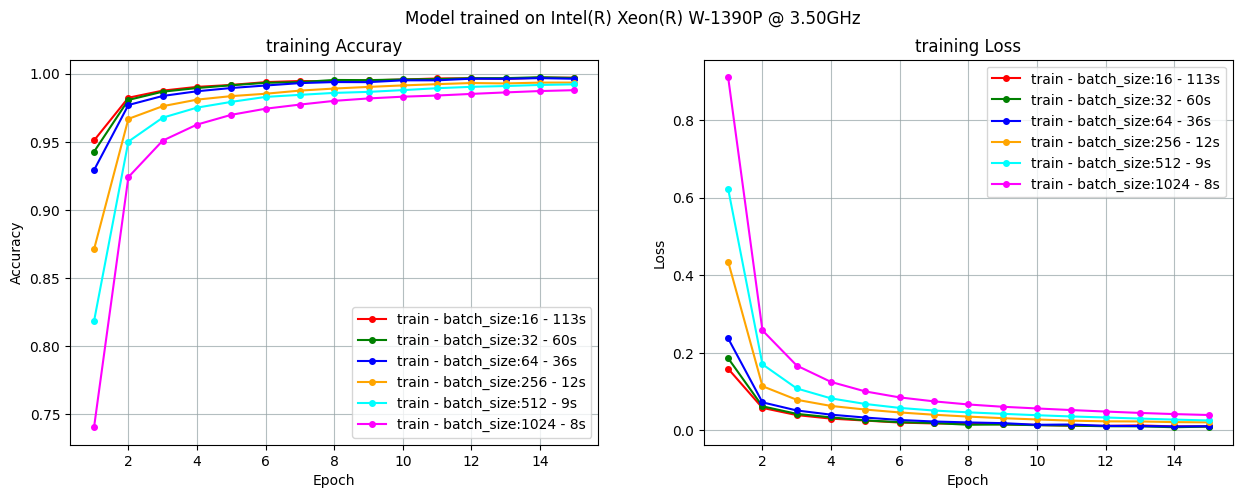

In [21]:
plot_loss_accuracy_vs_hyperparam(H, NB_IM_TRAIN, plot_valid=False,)

In [27]:
for h, r in zip(H, R):
        nb_epoch   = h.params['nb_epoch']
        batch_size = h.params['batch_size']
        elaps_time = h.params['elaps'].split()[2]
        test_loss, test_acc = r['evaluate']
        print(f'batch_size:{batch_size:4d} time:{elaps_time:4s} test_acc: {test_acc:.3f} test_loss:{test_loss:.3f}')


batch_size:  16 time:113s test_acc: 0.990 test_loss:0.039
batch_size:  32 time:60s  test_acc: 0.986 test_loss:0.061
batch_size:  64 time:36s  test_acc: 0.988 test_loss:0.058
batch_size: 256 time:12s  test_acc: 0.982 test_loss:0.057
batch_size: 512 time:9s   test_acc: 0.988 test_loss:0.037
batch_size:1024 time:8s   test_acc: 0.987 test_loss:0.040


### Same trainings with the early-stop callback

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

H, R = [], []
nb_epoch = 15

for bs in (16, 32, 64, 256, 512, 1024):
    print(f'batch_size={bs}, {SEED=} ', end="")
    t0 = time()
    
    # Build a new model at each lopp lap, with seed set:
    model = build_CNN(IM_SHAPE, seed=SEED)


    callbacks_list = [
        EarlyStopping(monitor='val_loss',  # The parameter to monitor
                      patience=1,          # accept that 'val_accuracy' decrease 1 time
                      restore_best_weights=True,
                      verbose=1)
    ]
        
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=nb_epoch,  # the total number of successive trainings
                     batch_size=bs,    # split the train dataset in multiple batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0,
                     callbacks = callbacks_list)
    
    elaps = elapsed_time_since(t0)
    print(f' Train {elaps}', flush=True) 
    
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    predict_labels = np.argmax(model.predict(x_test, verbose=0), axis=-1)
    R.append({'evaluate':(test_loss, test_acc), 'elaps':elaps, 'y_test':y_test, 'predict_labels':predict_labels})

    hist.params['nb_epoch']   = nb_epoch
    hist.params['batch_size'] = bs
    hist.params['seed']       = SEED
    hist.params['elaps']      = elaps
    H.append(hist)  


batch_size=16, SEED=1234 Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
 Train Elapsed time 17s -> 00:00:17
batch_size=32, SEED=1234 Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 5.
 Train Elapsed time 27s -> 00:00:27
batch_size=64, SEED=1234 Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 5.
 Train Elapsed time 15s -> 00:00:15
batch_size=256, SEED=1234 Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 6.
 Train Elapsed time 6s -> 00:00:06
batch_size=512, SEED=1234 Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 6.
 Train Elapsed time 5s -> 00:00:05
batch_size=1024, SEED=1234 Restoring model weights from the end of the best epoch: 15.
 Train Elapsed time 7s -> 00:00:07


In [44]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from seaborn import heatmap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from time import time
from cpuinfo import get_cpu_info

def plot_loss_accuracy_vs_hyperparam(hist:list, 
                                     train_data_set_size:int,
                                     min_acc:float=None,
                                     max_acc:float=None,
                                     min_loss:float=None,
                                     max_loss:float=None, 
                                     plot_train:bool=True, 
                                     plot_valid:bool=True,
                                     figsize=(15,5)):
    '''
    Plot training & validation loss & accuracy values, giving an argument
    'hist' of type 'tensorflow.python.keras.callbacks.History'. 
    '''
    
    custom_lines = [Line2D([0], [0], color='blue', lw=1, marker='o'),
                    Line2D([0], [0], color='orange', lw=1, marker='o')]
    colors = ('red', 'green', 'blue', 'orange', 'cyan', 'magenta')

    title_acc = {(True, True): "Model Accuracy",
             (True, False): "training Accuray",
             (False, True): "Validation Accuracy"}
    title_val = {(True, True): "Model Loss",
             (True, False): "training Loss",
             (False, True): "Validation Loss"}

    if not isinstance(hist, list): hist = [hist]
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    fig.suptitle(f"Model trained on {get_cpu_info()['brand_raw']}")

    if plot_train and plot_valid: 
        line = 'o:'
    else:
        line = 'o-'

    # Plot training & validation accuracy
    for (i, h) in enumerate(hist):
        nb_epoch    = h.params['nb_epoch']
        batch_size  = h.params['batch_size']
        elaps_time  = h.params['elaps'].split()[2]
        epoch_array = np.array(h.epoch)+1

        if h.history.get('accuracy') and plot_train:
            ax1.plot(epoch_array, h.history['accuracy'], line, markersize=4,
                     color=colors[i], label=f'train - batch_size:{batch_size} - {elaps_time}')
        if h.history.get('val_accuracy') and plot_valid:
            ax1.plot(epoch_array, h.history['val_accuracy'], 'o-', markersize=4,
                     color=colors[i], label=f'valid - batch_size:{batch_size} - {elaps_time}')
    ax1.set_title(title_acc[(plot_train, plot_valid)])
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch') 
    y_min, y_max = ax1.get_ylim()
    if min_acc is not None: y_min = min_acc
    if max_acc is not None: y_max = max_acc
    ax1.set_ylim((y_min, y_max))
    ax1.grid(which='major', color='xkcd:cool grey',  linestyle='-',  alpha=0.7)
    ax1.grid(which='minor', color='xkcd:light grey', linestyle='--', alpha=0.5)
    ax1.legend(loc='lower right')
    #ax1.set_xticks(np.arange(1, len(h.epoch)+1))
    
    
    # Plot training & validation loss values
    for (i, h) in enumerate(hist):
        nb_epoch   = h.params['nb_epoch']
        batch_size = h.params['batch_size']
        elaps_time = h.params['elaps'].split()[2]
        epoch_array = np.array(h.epoch)+1
        if h.history.get('loss') and plot_train:
            ax2.plot(epoch_array, h.history['loss'], line, markersize=4,
                     color=colors[i], label=f'train - batch_size:{batch_size} - {elaps_time}')
        if h.history.get('val_loss') and plot_valid:
            ax2.plot(epoch_array, h.history['val_loss'], 'o-', markersize=4,
                     color=colors[i], label=f'valid - batch_size:{batch_size} - {elaps_time}')
    ax2.set_title(title_val[(plot_train, plot_valid)])
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    y_min, y_max = ax2.get_ylim()
    if min_loss is not None: y_min = min_loss
    if max_loss is not None: y_max = max_loss
    ax2.set_ylim((y_min, y_max))
    ax2.grid(which='major', color='xkcd:cool grey',  linestyle='-',  alpha=0.7)
    ax2.grid(which='minor', color='xkcd:light grey', linestyle='--', alpha=0.5)
    ax2.legend(loc='upper right')
    #ax2.set_xticks(np.arange(1, len(h.epoch)+1))

    plt.show()


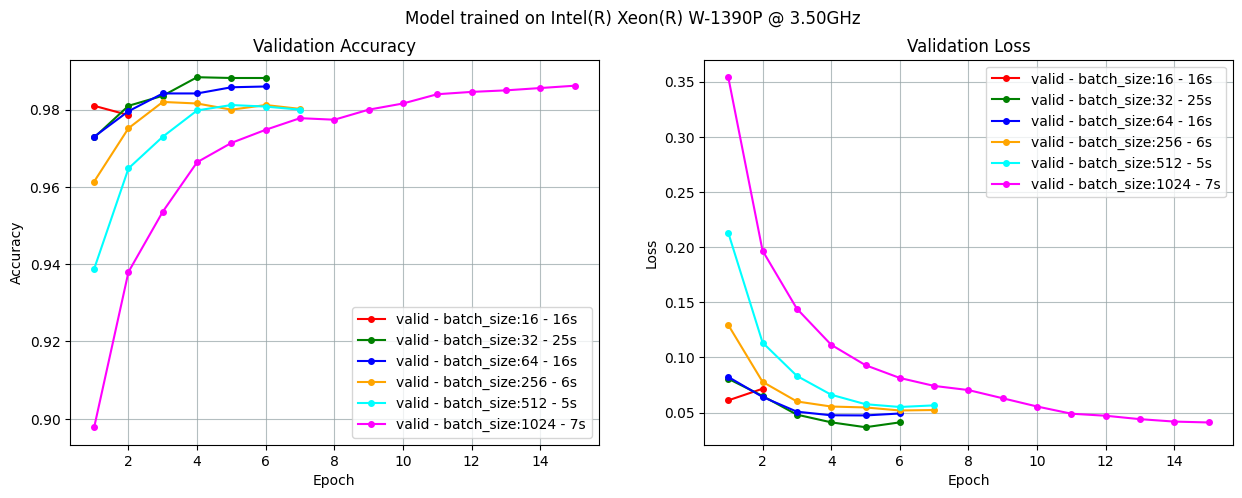

In [45]:
plot_loss_accuracy_vs_hyperparam(H, NB_IM_TRAIN, plot_train=False,)

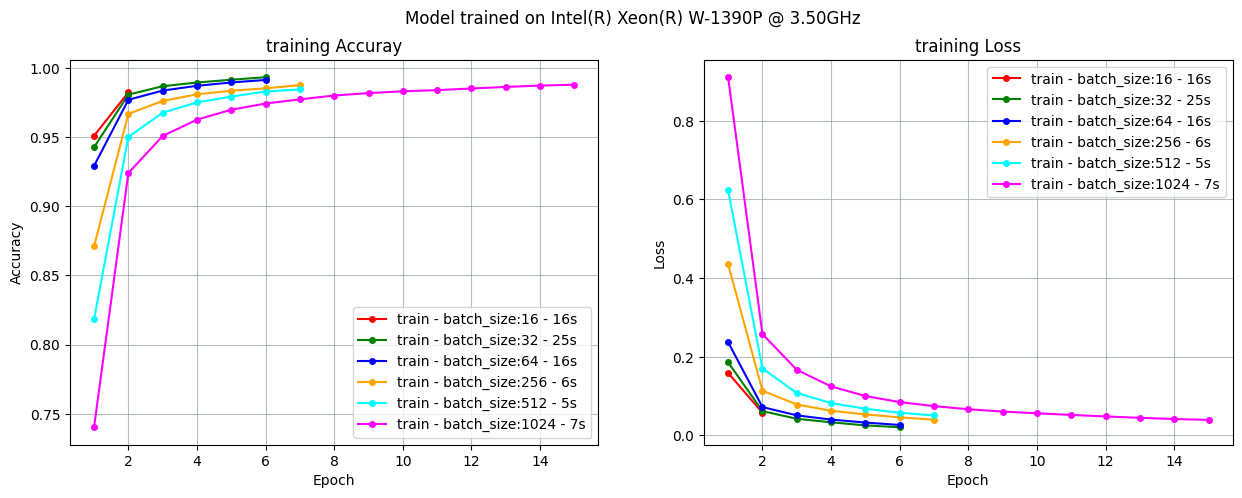

In [47]:
plot_loss_accuracy_vs_hyperparam(H, NB_IM_TRAIN, plot_valid=False,)

In [46]:
for h, r in zip(H, R):
        nb_epoch   = h.params['nb_epoch']
        batch_size = h.params['batch_size']
        elaps_time = h.params['elaps'].split()[2]
        test_loss, test_acc = r['evaluate']
        print(f'batch_size:{batch_size:4d} time:{elaps_time:4s} test_acc: {test_acc:.3f} test_loss:{test_loss:.3f}')


batch_size:  16 time:16s  test_acc: 0.981 test_loss:0.064
batch_size:  32 time:25s  test_acc: 0.990 test_loss:0.035
batch_size:  64 time:16s  test_acc: 0.986 test_loss:0.044
batch_size: 256 time:6s   test_acc: 0.983 test_loss:0.050
batch_size: 512 time:5s   test_acc: 0.981 test_loss:0.054
batch_size:1024 time:7s   test_acc: 0.987 test_loss:0.040


## 6 - Autres ressources intéressantes... des vidéos :

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>